# Building RAG using LangChain

This tutorial will familiarize you with LangChain's document loader, embedding, and vector store abstractions. These abstractions are designed to support retrieval of data-- from (vector) databases and other sources-- for integration with LLM workflows. They are important for applications that fetch data to be reasoned over as part of model inference, as in the case of retrieval-augmented generation, or RAG (see our RAG tutorial here).

Here we will build a search engine over a PDF document. This will allow us to retrieve passages in the PDF that are similar to an input query.

## Prerequisites

You will need to provision the following Azure resources:
* Azure OpenAI with two models: GPT-4o and Embedding model.
* Azure AI Search.
You can run the terraform template from folder `../400_azure_ai_foundry` to create all of these resources by simply running the following commands.

```sh
terraform init
terraform plan -out tfplan
terraform apply tfplan
```

Then you will need to setup the values for the environment variables in file `.env`.

The following resources should be created.

![](images/resources.png)

## Documents and Document Loaders

LangChain implements a Document abstraction, which is intended to represent a unit of text and associated metadata. It has three attributes:

* page_content: a string representing the content;
* metadata: a dict containing arbitrary metadata;
* id: (optional) a string identifier for the document.

The metadata attribute can capture information about the source of the document, its relationship to other documents, and other information. Note that an individual Document object often represents a chunk of a larger document.

This tutorial requires the langchain-community and pypdf packages.

In [ ]:
%pip install langchain-community pypdf --quiet

## Loading documents

Let's load a PDF into a sequence of Document objects. We can consult the LangChain documentation for available PDF document loaders. Let's select PyPDFLoader, which is fairly lightweight.

In [91]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "./example_data/azure-for-architects.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

701


PyPDFLoader loads one Document object per PDF page. For each, we can easily access:

* The string content of the page;
* Metadata containing the file name and page number.

In [ ]:
print(f"{docs[200].page_content}\n")
print(docs[200].metadata)

## Option 1: Splitting/chunking text by characters

For both information retrieval and downstream question-answering purposes, a page may be too coarse a representation. Our goal in the end will be to retrieve `Document` objects that answer an input query, and further splitting our PDF will help ensure that the meanings of relevant portions of the document are not "washed out" by surrounding text.

We can use text splitters for this purpose. Here we will use a simple text splitter that partitions based on characters. We will split our documents into chunks of 1000 characters with 200 characters of overlap between chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it. We use the RecursiveCharacterTextSplitter, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

We set `add_start_index=True` so that the character index where each split Document starts within the initial Document is preserved as metadata attribute “start_index”.

In [92]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=0, 
    add_start_index=True
)
chunks = text_splitter.split_documents(docs)

print("Number of splits: ", len(chunks))

Number of splits:  1385


## Option 2: Splitting/chunking text based on Semantic similarity

If embeddings are sufficiently far apart, chunks are split.

At a high level, this splits into sentences, then groups into groups of 3 sentences, and then merges one that are similar in the embedding space.

This chunker works by determining when to "break" apart sentences. This is done by looking for differences in embeddings between any two sentences. When that difference is past some threshold, then they are split.

There are a few ways to determine what that threshold is, which are controlled by the breakpoint_threshold_type kwarg.

>Note: if the resulting chunk sizes are too small/big, the additional kwargs breakpoint_threshold_amount and min_chunk_size can be used for adjustments.

More details: https://python.langchain.com/docs/how_to/semantic-chunker/

Install Dependencies.

In [ ]:
%pip install --quiet langchain_experimental langchain_openai

To instantiate a SemanticChunker, we must specify an embedding model. Below we will use OpenAIEmbeddings.

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

# embeddings was defined earlier
text_splitter = SemanticChunker(embeddings)

# concatenate the documents
pages = [d.page_content for d in docs]
len(pages)

chunks = text_splitter.create_documents(pages)
len(chunks)

## Viewing the chunks

In [93]:
for chunk in chunks:
    print(chunk.page_content)
    print("---------------")

Ritesh Modi, Jack Lee, and Rithin Skaria
Create secure, scalable, high-availability 
applications on the cloud
Azure for Architects
Third Edition
---------------
Azure for Architects Third Edition
Copyright © 2020 Packt Publishing
All rights reserved. No part of this book may be reproduced, stored in a retrieval system, 
or transmitted in any form or by any means, without the prior written permission of the 
publisher, except in the case of brief quotations embedded in critical articles or reviews.
Every effort has been made in the preparation of this book to ensure the accuracy of 
the information presented. However, the information contained in this book is sold 
without warranty, either express or implied. Neither the authors, nor Packt Publishing, 
and its dealers and distributors will be held liable for any damages caused or alleged to 
be caused directly or indirectly by this book.
Packt Publishing has endeavored to provide trademark information about all of the 
companies and pr

## Count the number of tokens in a text

Like LLM models, Embedding models defines a `max input`. It is defined in number of `tokens`. The `max_input` for `text-embedding-3-large` is 8191 tokens. So we need to split the text into chunks of 8191 tokens or less. For that, you need to get the number of tokens in a text string.

In [102]:
%pip install tiktoken --quiet

Note: you may need to restart the kernel to use updated packages.


In [103]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name="cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

# Test the function
num_tokens_from_string("tiktoken is great!")

6

Count the number of tokens in each chunk. It should not exceed the max specified by the Embedding model (8191).

In [113]:
for chunk in chunks:
    num_tokens = num_tokens_from_string(chunk.page_content)
    if num_tokens > 8191:
        print(chunk.metadata["page"])
        print(num_tokens)
        print("---------------")

## Creating Embeddings

`Vector search` is a common way to store and search over unstructured data (such as unstructured text). The idea is to store numeric vectors that are associated with the text. Given a query, we can embed it as a vector of the same dimension and use vector similarity metrics (such as cosine similarity) to identify related text.

`LangChain` supports embeddings from dozens of providers. These models specify how text should be converted into a numeric vector. 

In [94]:
%pip install -qU langchain-openai --quiet
%pip install python-dotenv --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [95]:
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

if os.path.exists(".env"):
    load_dotenv(override=True)


embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_deployment=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
    openai_api_version=os.environ["AZURE_OPENAI_EMBEDDING_API_VERSION"],
)

In [96]:
vector_1 = embeddings.embed_query(chunks[0].page_content)
vector_2 = embeddings.embed_query(chunks[1].page_content)

print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])
print(vector_2[:10])

Generated vectors of length 3072

[0.010515968315303326, -0.01905210129916668, -0.017833741381764412, 0.022737640887498856, 0.008901641704142094, -0.006392581854015589, -0.011467811651527882, 0.024169212207198143, -0.0178185123950243, 0.02282901667058468]
[-0.002384420484304428, -0.014230713248252869, -0.017530273646116257, 0.012981644831597805, 0.021096978336572647, -0.03303893655538559, -0.021400220692157745, 0.027956021949648857, -0.031335003674030304, 0.007270587608218193]


Armed with a model for generating text embeddings, we can next store them in a special data structure that supports efficient similarity search.

## Vector stores for Azure AI Search

`LangChain VectorStore` objects contain methods for adding text and `Document` objects to the store, and querying them using various similarity metrics. They are often initialized with embedding models, which determine how text data is translated to numeric vectors.

`LangChain` includes a suite of integrations with different vector store technologies. Some vector stores are hosted by a provider (e.g., various cloud providers) and require specific credentials to use; some (such as `Postgres`) run in separate infrastructure that can be run locally or via a third-party; others can run in-memory for lightweight workloads.

In [97]:
%pip install --upgrade --quiet azure-search-documents
%pip install --upgrade --quiet azure-identity

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [98]:
from langchain_openai import AzureOpenAIEmbeddings, AzureOpenAIEmbeddings

embeddings: AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    azure_deployment=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
    openai_api_version=os.environ["AZURE_OPENAI_EMBEDDING_API_VERSION"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
)

## Create vector store instance

Create instance of the `AzureSearch` class using the embeddings from above.

In [128]:
from langchain_community.vectorstores.azuresearch import AzureSearch

# Specify additional properties for the Azure client such as the following https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/core/azure-core/README.md#configurations
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"],
    azure_search_key=os.environ["AZURE_SEARCH_SERVICE_ADMIN_KEY"],
    index_name=os.environ["AZURE_SEARCH_SERVICE_INDEX"],
    embedding_function=embeddings.embed_query,
    # Configure max retries for the Azure client
    additional_search_client_options={"retry_total": 3},
    relevance_score_fn="cosine",
)

## Insert text and embeddings into vector store

This step loads, chunks, and vectorizes the sample document, and then indexes the content into a search index on `Azure AI Search`.

In [129]:
# vector_store.add_documents(documents=chunks)

# You can import search documents into a specified index using HTTP POST. 
# For a large update, batching (up to 1000 documents per batch, or about 16 MB per batch) 
# is recommended and will significantly improve indexing performance.

# upload documents per batch of 300

for i in range(0, len(chunks), 300):
    print("Uploading doscuments from ", i, " to ", i+300)
    vector_store.add_documents(documents=chunks[i:i+300])

Uploading doscuments from  0  to  300
Uploading doscuments from  300  to  600
Uploading doscuments from  600  to  900
Uploading doscuments from  900  to  1200
Uploading doscuments from  1200  to  1500


Once we've instantiated a VectorStore that contains documents, we can query it. VectorStore includes methods for querying:

* Synchronously and asynchronously;
* By string query and by vector;
* With and without returning similarity scores;
* By similarity and maximum marginal relevance (to balance similarity with query to diversity in retrieved results).

## Perform a vector similarity search with relevance scores

Execute a pure vector similarity search using the `similarity_search_with_relevance_scores()` method. Queries that don't meet the threshold requirements are exluded.

In [130]:
from pprint import pprint

docs_and_scores = vector_store.similarity_search_with_relevance_scores(
    query="Who are the authors of the book Azure for Architects ?",
    k=4,
    score_threshold=0.70,
)

pprint(docs_and_scores)

[(Document(metadata={'id': 'NmMzNDQyMjUtZDAwMS00MTFmLTkyZmItOTIyOTYwMzAyZTc4', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 'subject': 'Create secure, scalable, high-availability applications on the cloud', 'title': 'Azure for Architects, Third Edition', 'trapped': '/False', 'source': './example_data/azure-for-architects.pdf', 'total_pages': 701, 'page': 1, 'page_label': 'a', 'start_index': 0}, page_content='Ritesh Modi, Jack Lee, and Rithin Skaria\nCreate secure, scalable, high-availability \napplications on the cloud\nAzure for Architects\nThird Edition'),
  0.77307135),
 (Document(metadata={'id': 'ZGE2NGJjMGUtOTA1Yy00MjNkLTk5M2QtM2I4NDc4OGUzZDM1', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 's

## Perform a hybrid search

`Hybrid search` combines keyword and semantic similarity, marrying the benefits of both approaches.
Execute hybrid search using the `search_type` or `hybrid_search()` method. Vector and nonvector text fields are queried in parallel, results are merged, and top matches of the unified result set are returned.

In [131]:
# Perform a hybrid search using the search_type parameter
docs = vector_store.similarity_search(
    query="Who are the authors of the book Azure for Architects ?",
    k=3,
    search_type="hybrid",
)
pprint(docs)

[Document(metadata={'id': 'NmMzNDQyMjUtZDAwMS00MTFmLTkyZmItOTIyOTYwMzAyZTc4', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 'subject': 'Create secure, scalable, high-availability applications on the cloud', 'title': 'Azure for Architects, Third Edition', 'trapped': '/False', 'source': './example_data/azure-for-architects.pdf', 'total_pages': 701, 'page': 1, 'page_label': 'a', 'start_index': 0}, page_content='Ritesh Modi, Jack Lee, and Rithin Skaria\nCreate secure, scalable, high-availability \napplications on the cloud\nAzure for Architects\nThird Edition'),
 Document(metadata={'id': 'MGQ2YmY4ZGEtM2JlYS00MmZmLWI5MTItZDM0OTU3NTI2Y2Uz', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 'subject': 'Create 

## Retrieval and Generation using LangGraph

Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

For generation, we will use the chat model selected at the start of the tutorial.

We’ll use a prompt for `RAG` that is checked into the `LangChain` prompt hub.

In [132]:
%pip install --quiet --upgrade langgraph

Note: you may need to restart the kernel to use updated packages.


In [133]:
from langchain_openai import AzureChatOpenAI
from langchain import hub

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

In [134]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

question = "Who are the authors of the book Azure for Architects and when it was published ?"

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)

print(answer.content)

c:\Users\hodellai\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The authors of *Azure for Architects, Third Edition* are Rithin Skaria and Ritesh Modi. It was published in 2020.


In [135]:
from langchain_openai import AzureChatOpenAI
from langchain import hub
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

response = graph.invoke({"question": "Who are the authors of the book Azure for Architects and when it was published ?"})

print(response["answer"])

c:\Users\hodellai\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The authors of the book *Azure for Architects* (Third Edition), published in 2020, are Rithin Skaria and Ritesh Modi.


LangGraph also comes with built-in utilities for visualizing the control flow of your application.

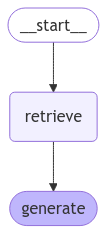

In [136]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))